### Modules

In [6]:
# basic
import os, sys, glob, umap, pybedtools
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from liftover import get_lifter
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, silhouette_samples
from sklearn.manifold import TSNE
from matplotlib_venn import venn2, venn3
from matplotlib.lines import Line2D

In [2]:
sys.path.insert(1, '/home/bo-yi/package/m6atm/m6atm/preprocess')
from ReadClass import *

In [3]:
sys.path.insert(1, '/home/bo-yi/package/m6atm/m6atm/train')
from ModelData import *

In [4]:
out_dir = '/home/bo-yi/paper'

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Fig 3A

In [ ]:
def roc_val(pred_table, col):
    
    y_pred = pred_table[col]
    y_true = pred_table['gt']

    fpr, tpr, thersholds = roc_curve(y_true, y_pred, pos_label = 1)
    roc_auc = auc(fpr, tpr)

    out = [fpr, tpr, roc_auc]
    
    return out

def pr_val(pred_table, col):
    
    y_pred = pred_table[col]
    y_true = pred_table['gt']

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred, pos_label = 1)
    pr_auc = auc(recall, precision)

    out = [precision, recall, pr_auc]
    
    return out

In [ ]:
bmk_dir_ivt20 = '/home/bo-yi/data/DRS/20230326_IVT1mix20/bmk'
bmk_dir_ivt0 = '/home/bo-yi/data/DRS/20230326_IVT1mix0/bmk'
DRACH = extend_ambiguous('DRACH')

In [ ]:
### find shared sites
# m6ATM
pred_pos = pd.read_csv('/home/bo-yi/data/DRS/20230326_IVT1mix20/preprocessed/results.csv', index_col = 0)
pred_pos['site'] = [x+'_'+str(y)+'_p' for x, y in zip(pred_pos['transcript'], pred_pos['position'])]

pred_neg = pd.read_csv('/home/bo-yi/data/DRS/20230326_IVT1mix0/preprocessed/results.csv', index_col = 0)
pred_neg['site'] = [x+'_'+str(y)+'_n' for x, y in zip(pred_neg['transcript'], pred_neg['position'])]

pred_table = pd.concat([pred_pos, pred_neg], axis = 0)
pred_table['gt'] = [1]*pred_pos.shape[0]+[0]*pred_neg.shape[0]

# m6Anet
pred_m6anet_pos = pd.read_csv(os.path.join(bmk_dir_ivt20, 'm6anet', 'data.site_proba.csv'))
pred_m6anet_pos['predicted'] = [1 if i>=0.5 else 0 for i in pred_m6anet_pos['probability_modified'] ]
pred_m6anet_pos['site'] = [x+'_'+str(y)+'_p' for x, y in zip(pred_m6anet_pos['transcript_id'], pred_m6anet_pos['transcript_position'])]

pred_m6anet_neg = pd.read_csv(os.path.join(bmk_dir_ivt0, 'm6anet', 'data.site_proba.csv'))
pred_m6anet_neg['site'] = [x+'_'+str(y)+'_n' for x, y in zip(pred_m6anet_neg['transcript_id'], pred_m6anet_neg['transcript_position'])]

pred_m6anet = pd.concat([pred_m6anet_pos, pred_m6anet_neg], axis = 0)
pred_m6anet['gt'] = [1]*pred_m6anet_pos.shape[0]+[0]*pred_m6anet_neg.shape[0]

# m6a basecaller
pred_m6abase_pos = pd.read_csv(os.path.join(bmk_dir_ivt20, 'm6abase', 'mod.tsv'), sep = '\t')
pred_m6abase_pos.columns = ['chr', 'pos', 'ref_base', 'strand', 'mod', 'coverage', 'base_accuracy', 'ratio', 'probability']
pred_m6abase_pos['site'] = [x+'_'+str(y-1)+'_p' for x, y in zip(pred_m6abase_pos['chr'], pred_m6abase_pos['pos'])]
pred_m6abase_pos = pred_m6abase_pos[pred_m6abase_pos.site.isin(pred_pos.site.tolist())]
pred_m6abase_pos['probability'] = pred_m6abase_pos['probability'].replace(np.nan, 0)

pred_m6abase_neg = pd.read_csv(os.path.join(bmk_dir_ivt0, 'm6abase', 'mod.tsv'), sep = '\t')
pred_m6abase_neg.columns = ['chr', 'pos', 'ref_base', 'strand', 'mod', 'coverage', 'base_accuracy', 'ratio', 'probability']
pred_m6abase_neg['site'] = [x+'_'+str(y-1)+'_n' for x, y in zip(pred_m6abase_neg['chr'], pred_m6abase_neg['pos'])]
pred_m6abase_neg = pred_m6abase_neg[pred_m6abase_neg.site.isin(pred_neg.site.tolist())]
pred_m6abase_neg['probability'] = pred_m6abase_neg['probability'].replace(np.nan, 0)

pred_m6abase = pd.concat([pred_m6abase_pos, pred_m6abase_neg], axis = 0)
pred_m6abase['gt'] = [1]*pred_m6abase_pos.shape[0]+[0]*pred_m6abase_neg.shape[0]

# EpiNano
pred_epinano_pos = pd.read_csv(os.path.join(bmk_dir_ivt20, 'epinano', 'pred.csv'))
pred_epinano_pos = pred_epinano_pos.loc[:,['#Kmer', 'Window', 'Ref', 'Strand', 'Coverage', 'prediction', 'ProbM']]
pred_epinano_pos['site'] = [x+'_'+str(int(y.split('-')[0])+1)+'_p' for x, y in zip(pred_epinano_pos['Ref'], pred_epinano_pos['Window'])]
pred_epinano_pos = pred_epinano_pos[pred_epinano_pos.site.isin(pred_pos.site.tolist())]

pred_epinano_neg = pd.read_csv(os.path.join(bmk_dir_ivt0, 'epinano', 'pred.csv'))
pred_epinano_neg = pred_epinano_neg.loc[:,['#Kmer', 'Window', 'Ref', 'Strand', 'Coverage', 'prediction', 'ProbM']]
pred_epinano_neg['site'] = [x+'_'+str(int(y.split('-')[0])+1)+'_n' for x, y in zip(pred_epinano_neg['Ref'], pred_epinano_neg['Window'])]
pred_epinano_neg = pred_epinano_neg[pred_epinano_neg.site.isin(pred_neg.site.tolist())]

pred_epinano = pd.concat([pred_epinano_pos, pred_epinano_neg], axis = 0)
pred_epinano['gt'] = [1]*pred_epinano_pos.shape[0]+[0]*pred_epinano_neg.shape[0]

# Tombo
pred_tombo_pos = pd.read_csv(os.path.join(bmk_dir_ivt20, 'tombo', 'pred.bed'), sep = '\t', header = None)
pred_tombo_pos.columns = ['chr', 'start', 'end', 'id', 'probability']
pred_tombo_pos['site'] = [x+'_'+str(y)+'_p' for x, y in zip(pred_tombo_pos['chr'], pred_tombo_pos['start'])]

pred_tombo_neg = pd.read_csv(os.path.join(bmk_dir_ivt0, 'tombo', 'pred.bed'), sep = '\t', header = None)
pred_tombo_neg.columns = ['chr', 'start', 'end', 'id', 'probability']
pred_tombo_neg['site'] = [x+'_'+str(y)+'_n' for x, y in zip(pred_tombo_neg['chr'], pred_tombo_neg['start'])]

pred_tombo = pd.concat([pred_tombo_pos, pred_tombo_neg], axis = 0)
pred_tombo['gt'] = [1]*pred_tombo_pos.shape[0]+[0]*pred_tombo_neg.shape[0]

# MINES
pred_mines_pos = pd.read_csv(os.path.join(bmk_dir_ivt20, 'mines', 'pred.bed'), sep = '\t', header = None)
pred_mines_pos.columns = ['chr', 'start', 'end', 'motif', 'id', 'strand', 'probability', 'coverage']
pred_mines_pos['site'] = [x+'_'+str(y-1)+'_p' for x, y in zip(pred_mines_pos['chr'], pred_mines_pos['start'])]

pred_mines_neg = pd.read_csv(os.path.join(bmk_dir_ivt0, 'mines', 'pred.bed'), sep = '\t', header = None)
pred_mines_neg.columns = ['chr', 'start', 'end', 'motif', 'id', 'strand', 'probability', 'coverage']
pred_mines_neg['site'] = [x+'_'+str(y-1)+'_n' for x, y in zip(pred_mines_neg['chr'], pred_mines_neg['start'])]

pred_mines = pd.concat([pred_mines_pos, pred_mines_neg], axis = 0)
pred_mines['gt'] = [1]*pred_mines_pos.shape[0]+[0]*pred_mines_neg.shape[0]

# sites
sites = set.intersection(set(pred_table['site']),
                         set(pred_m6anet['site']),
                         set(pred_m6abase['site']),
                         set(pred_epinano['site']),
                         set(pred_tombo['site']),
                         set(pred_mines['site']))

pred_table = pred_table[pred_table.site.isin(sites)]
pred_m6anet = pred_m6anet[pred_m6anet.site.isin(sites)]
pred_m6abase = pred_m6abase[pred_m6abase.site.isin(sites)]
pred_epinano = pred_epinano[pred_epinano.site.isin(sites)]
pred_tombo = pred_tombo[pred_tombo.site.isin(sites)]
pred_mines = pred_mines[pred_mines.site.isin(sites)]

In [ ]:
# auc roc
roc_m6atm = roc_val(pred_table, 'probability')
roc_m6anet = roc_val(pred_m6anet, 'probability_modified')
roc_m6abase = roc_val(pred_m6abase, 'probability')
roc_epinano = roc_val(pred_epinano, 'ProbM')
roc_tombo = roc_val(pred_tombo, 'probability')
roc_mines = roc_val(pred_mines, 'probability')

# auc pr
pr_m6atm = pr_val(pred_table, 'probability')
pr_m6anet = pr_val(pred_m6anet, 'probability_modified')
pr_m6abase = pr_val(pred_m6abase, 'probability')
pr_epinano = pr_val(pred_epinano, 'ProbM')
pr_tombo = pr_val(pred_tombo, 'probability')
pr_mines = pr_val(pred_mines, 'probability')

In [ ]:
### roc plot
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette('Set2')
fig, ax = plt.subplots(figsize = (8, 6)) # figure size

plt.plot(roc_m6atm[0], roc_m6atm[1], color = tab_color[0], lw = 2, label = 'm6ATM (area = {0:.3f})'.format(roc_m6atm[2]))
plt.plot(roc_m6anet[0], roc_m6anet[1], color = tab_color[1], lw = 2, label = 'm6Anet (area = {0:.3f})'.format(roc_m6anet[2]))
plt.plot(roc_m6abase[0], roc_m6abase[1], color = tab_color[2], lw = 2, label = 'm6ABasecaller (area = {0:.3f})'.format(roc_m6abase[2]))
plt.plot(roc_epinano[0], roc_epinano[1], color = tab_color[3], lw = 2, label = 'EpiNano (area = {0:.3f})'.format(roc_epinano[2]))
plt.plot(roc_tombo[0], roc_tombo[1], color = tab_color[4], lw = 2, label = 'Tombo (area = {0:.3f})'.format(roc_tombo[2]))
plt.plot(roc_mines[0], roc_mines[1], color = tab_color[5], lw = 2, label = 'MINES (area = {0:.3f})'.format(roc_mines[2]))

plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize = 25)
plt.ylabel('True Positive Rate', fontsize = 25)  
plt.legend(loc = 'lower right', fontsize = 12)

plt.tick_params(labelsize = 16)
# plt.savefig(os.path.join(out_dir, 'fig3a.png'), bbox_inches = 'tight', dpi = 300)

In [ ]:
### pr plot
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette('Set2')
fig, ax = plt.subplots(figsize = (8, 6)) # figure size

plt.plot(pr_m6atm[1], pr_m6atm[0], color = tab_color[0], lw = 2, label = 'm6ATM (area = {0:.3f})'.format(pr_m6atm[2]))
plt.plot(pr_m6anet[1], pr_m6anet[0], color = tab_color[1], lw = 2, label = 'm6Anet (area = {0:.3f})'.format(pr_m6anet[2]))
plt.plot(pr_m6abase[1], pr_m6abase[0], color = tab_color[2], lw = 2, label = 'm6ABasecaller (area = {0:.3f})'.format(pr_m6abase[2]))
plt.plot(pr_epinano[1], pr_epinano[0], color = tab_color[3], lw = 2, label = 'EpiNano (area = {0:.3f})'.format(pr_epinano[2]))
plt.plot(pr_tombo[1], pr_tombo[0], color = tab_color[4], lw = 2, label = 'Tombo (area = {0:.3f})'.format(pr_tombo[2]))
plt.plot(pr_mines[1], pr_mines[0], color = tab_color[5], lw = 2, label = 'MINES (area = {0:.3f})'.format(pr_mines[2]))

plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])

plt.xlabel('Recall', fontsize = 25)
plt.ylabel('Precision', fontsize = 25)  
plt.legend(loc = 'lower right', fontsize = 12)

plt.tick_params(labelsize = 16)
plt.savefig(os.path.join(out_dir, 'fig3s_pr_ivt.png'), bbox_inches = 'tight', dpi = 300)

### Fig 3B


In [ ]:
def add_kmer(row):
    
    tx = row['transcript']
    pos = row['position']-1
    motif = ref_dict_tx[tx][pos-2:pos+3]
    motif = ''.join(motif)
    
    return motif

#### HEK293

In [ ]:
# temp dir 
temp_dir = os.path.join('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed', 'temp')
os.makedirs(temp_dir, exist_ok = True)

In [ ]:
# # to bag
# bag_class = ATMbag('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed', processes = 48)
# bag_class.to_bag(temp_dir)

In [ ]:
# prediction
bag_data_list = sorted(glob.glob(os.path.join(temp_dir, 'bag_*.npy')))
bag_meta_list = sorted(glob.glob(os.path.join(temp_dir, 'site_*.csv')))

results = []
for f1, f2 in zip(bag_data_list, bag_meta_list):

    ### bags
    bag_data = np.load(f1, allow_pickle = True)
    bag_meta = pd.read_csv(f2, index_col = 0)

    ### dataloader
    dataset = WNBagloader(data = list(bag_data),
                          transform = transforms.Compose([ToTensor(device = 'cuda')]),
                          site = bag_meta['site'],
                          coverage = bag_meta['coverage'])

    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)

    ### prediction
    dsmil_pth = '/home/bo-yi/package/m6atm/m6atm/model/dsmil_ivt_80.pth'
    classifier_pth = '/home/bo-yi/package/m6atm/m6atm/model/classifer_ivt.pth'
    result = dsmil_pred(dsmil_pth, classifier_pth, dataloader, out_dir = temp_dir)
    results.append(result)

results = pd.concat(results, axis = 0)
results = results.reset_index(drop = True)

### save
results.to_csv(os.path.join('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed', 'results.csv'))

In [ ]:
tx_file = '/home/bo-yi/data/ref/enst_hg38Tables.tsv'
ref_tx = '/home/bo-yi/data/ref/GRCh38_rna_ensembl.fa'
ref_gn = '/home/bo-yi/data/ref/hg38.fa'

In [ ]:
tx_df = pd.read_csv(tx_file, sep = '\t')
tx_df['name'] = [i.split('.')[0] for i in tx_df['name']]
ref_dict_tx = get_ref_dict(ref_tx)
ref_dict_gn = get_ref_dict(ref_gn)

In [ ]:
bmk_dir_hek293 = '/home/bo-yi/data/DRS/20210806_HEK293-WT/bmk'
DRACH = extend_ambiguous('DRACH')

In [ ]:
results = pd.read_csv(os.path.join('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed', 'results_ivt20.csv'))
results_gn = tx_to_gn(results, tx_df, ref_dict_gn)
results_gn.to_csv(os.path.join('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed', 'results_gn.csv'))

In [ ]:
pred_m6anet = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6anet', 'data.site_proba.csv'))
pred_m6anet.columns = ['transcript', 'position', 'coverage', 'probability', 'motif', 'ratio']
pred_m6anet['m6a'] = '-'
pred_m6anet['transcript'] = [i.split('.')[0] for i in pred_m6anet['transcript']]

pred_m6anet_gn = tx_to_gn(pred_m6anet, tx_df, ref_dict_gn)
pred_m6anet_gn.to_csv(os.path.join(os.path.join(bmk_dir_hek293, 'm6anet', 'pred_gn.csv')))

In [ ]:
pred_m6abase = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6abase', 'mod.tsv'), sep = '\t')
pred_m6abase.columns = ['transcript', 'position', 'ref_base', 'strand', 'm6a', 'coverage', 'base_accuracy', 'ratio', 'probability']
pred_m6abase = pred_m6abase.loc[:,['transcript', 'position', 'coverage', 'probability', 'ratio', 'm6a', 'ref_base']]
pred_m6abase = pred_m6abase[pred_m6abase['ref_base'] == 'A']
pred_m6abase['probability'] = pred_m6abase['probability'].replace(np.nan, 0)
pred_m6abase['motif'] = pred_m6abase.apply(add_kmer, axis = 1)
pred_m6abase = pred_m6abase[pred_m6abase['motif'].isin(DRACH)]
pred_m6abase['transcript'] = [i.split('.')[0] for i in pred_m6abase['transcript']]

pred_m6abase_gn = tx_to_gn(pred_m6abase, tx_df, ref_dict_gn)
pred_m6abase_gn.to_csv(os.path.join(os.path.join(bmk_dir_hek293, 'm6abase', 'pred_gn.csv')))

In [ ]:
pred_tombo = pd.read_csv(os.path.join(bmk_dir_hek293, 'tombo', 'pred.bed'), sep = '\t', header = None)
pred_tombo.columns = ['transcript', 'start', 'position', 'id', 'probability']
pred_tombo['ratio'] = 0
pred_tombo['m6a'] = '-'
pred_tombo['motif'] = pred_tombo.apply(add_kmer, axis = 1)

pred_tombo_bed = pybedtools.BedTool.from_dataframe(df = pred_tombo)
coverage_bed = pybedtools.BedTool(os.path.join(bmk_dir_hek293, 'tombo', 'hek293wt.coverage.plus.bedgraph'))
pred_tombo_bed = pred_tombo_bed.intersect(coverage_bed, wb = True, wa = True)
pred_tombo_bed = pred_tombo_bed.to_dataframe()

pred_tombo['coverage'] = pred_tombo_bed['blockStarts']

pred_tombo['transcript'] = [i.split('.')[0] for i in pred_tombo['transcript']]

pred_tombo_gn = tx_to_gn(pred_tombo, tx_df, ref_dict_gn)
pred_tombo_gn.to_csv(os.path.join(os.path.join(bmk_dir_hek293, 'tombo', 'pred_gn.csv')))

In [ ]:
pred_mines = pd.read_csv(os.path.join(bmk_dir_hek293, 'mines', 'pred.bed'), sep = '\t', header = None)
pred_mines.columns = ['transcript', 'start', 'position', 'motif', 'id', '_strand', 'probability', 'coverage']
pred_mines['probability'] = pred_mines['probability'].replace('.', 0)
pred_mines['probability'] = pred_mines['probability'].astype('float')
pred_mines['ratio'] = 0
pred_mines['m6a'] = '-'
pred_mines['transcript'] = [i.split('.')[0] for i in pred_mines['transcript']]

pred_mines_gn = tx_to_gn(pred_mines, tx_df, ref_dict_gn)
pred_mines_gn.to_csv(os.path.join(os.path.join(bmk_dir_hek293, 'mines', 'pred_gn.csv')))

In [ ]:
gt_table = pd.read_csv(os.path.join(out_dir, 'gt_sac_hek293.csv'), index_col = 0)
gt_sites = sorted([x+'_'+str(y) for x,y in zip(gt_table['chr'], gt_table['center'])])

gt_table_u = pd.read_csv(os.path.join(out_dir, 'gt_usites_hek293.csv'), index_col = 0)
gt_sites_u = sorted([x+'_'+str(y) for x,y in zip(gt_table_u['chr'], gt_table_u['center'])])
coverage = 50

### m6atm
pred = pd.read_csv('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed/results_gn.csv', index_col = 0)
pred = pred[pred.motif.isin(DRACH)]
pred = pred[pred.coverage>=coverage]
pred['gt'] = pred['gn_site'].isin(gt_sites)

### m6anet
pred_m6anet = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6anet', 'pred_gn.csv'))
pred_m6anet = pred_m6anet[pred_m6anet.coverage>=coverage]
pred_m6anet['gt'] = pred_m6anet['gn_site'].isin(gt_sites)

### m6abase
pred_m6abase = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6abase', 'pred_gn.csv'))
pred_m6abase = pred_m6abase[pred_m6abase.coverage>=coverage]
pred_m6abase['gt'] = pred_m6abase['gn_site'].isin(gt_sites)

### tombo
pred_tombo = pd.read_csv(os.path.join(bmk_dir_hek293, 'tombo', 'pred_gn.csv'))
pred_tombo = pred_tombo[pred_tombo.coverage>=coverage]
pred_tombo['gt'] = pred_tombo['gn_site'].isin(gt_sites)

### mines
pred_mines = pd.read_csv(os.path.join(bmk_dir_hek293, 'mines', 'pred_gn.csv'))
pred_mines = pred_mines[pred_mines.coverage>=coverage]
pred_mines['gt'] = pred_mines['gn_site'].isin(gt_sites)

# sites
sites = set.intersection(set(pred['gn_site']), set(pred_m6anet['gn_site']), set(pred_m6abase['gn_site']),
                         set(pred_tombo['gn_site']), set(pred_mines['gn_site']))

pred = pred[pred.gn_site.isin(sites)]

### m6atm
# sites not in gt_m6A sites
pred_pos = pred[pred['gt'] == True]

pred_gt_n = pred[pred['gt'] == False]
pred_gt_not_u = pred_gt_n[~pred_gt_n['gn_site'].isin(gt_sites_u)]
pred_neg = pred_gt_not_u.sample(n = pred[pred['gt'] == True].shape[0], random_state = 0)

pred_all = pd.concat([pred_pos, pred_neg], axis = 0)

roc_m6atm = roc_val(pred_all, 'probability')
pr_m6atm = pr_val(pred_all, 'probability')

sites = pred_all['gn_site'].tolist()

### m6anet
pred_m6anet_all = pred_m6anet[pred_m6anet.gn_site.isin(sites)]
roc_m6anet = roc_val(pred_m6anet_all, 'probability')
pr_m6anet = pr_val(pred_m6anet_all, 'probability')

### m6abase
pred_m6abase_all = pred_m6abase[pred_m6abase.gn_site.isin(sites)]
roc_m6abase = roc_val(pred_m6abase_all, 'probability')
pr_m6abase = pr_val(pred_m6abase_all, 'probability')

### tombo
pred_tombo_all = pred_tombo[pred_tombo.gn_site.isin(sites)]
roc_tombo = roc_val(pred_tombo_all, 'probability')
pr_tombo = pr_val(pred_tombo_all, 'probability')

### mines
pred_mines_all = pred_mines[pred_mines.gn_site.isin(sites)]
roc_mines = roc_val(pred_mines_all, 'probability')
pr_mines = pr_val(pred_mines_all, 'probability')

In [ ]:
### roc plot
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette('Set2')
fig, ax = plt.subplots(figsize = (8, 6)) # figure size

plt.plot(roc_m6atm[0], roc_m6atm[1], color = tab_color[0], lw = 2, label = 'm6ATM (area = {0:.3f})'.format(roc_m6atm[2]))
plt.plot(roc_m6anet[0], roc_m6anet[1], color = tab_color[1], lw = 2, label = 'm6Anet (area = {0:.3f})'.format(roc_m6anet[2]))
plt.plot(roc_m6abase[0], roc_m6abase[1], color = tab_color[2], lw = 2, label = 'm6ABasecaller (area = {0:.3f})'.format(roc_m6abase[2]))
plt.plot(roc_tombo[0], roc_tombo[1], color = tab_color[4], lw = 2, label = 'Tombo (area = {0:.3f})'.format(roc_tombo[2]))
plt.plot(roc_mines[0], roc_mines[1], color = tab_color[5], lw = 2, label = 'MINES (area = {0:.3f})'.format(roc_mines[2]))

plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize = 25)
plt.ylabel('True Positive Rate', fontsize = 25)  
plt.legend(loc = 'lower right', fontsize = 12)

plt.tick_params(labelsize = 16)

plt.savefig(os.path.join(out_dir, 'fig3b.png'), bbox_inches = 'tight', dpi = 300)

In [ ]:
### pr plot
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette('Set2')
fig, ax = plt.subplots(figsize = (8, 6)) # figure size

plt.plot(pr_m6atm[1], pr_m6atm[0], color = tab_color[0], lw = 2, label = 'm6ATM (area = {0:.3f})'.format(pr_m6atm[2]))
plt.plot(pr_m6anet[1], pr_m6anet[0], color = tab_color[1], lw = 2, label = 'm6Anet (area = {0:.3f})'.format(pr_m6anet[2]))
plt.plot(pr_m6abase[1], pr_m6abase[0], color = tab_color[2], lw = 2, label = 'm6ABasecaller (area = {0:.3f})'.format(pr_m6abase[2]))
plt.plot(pr_tombo[1], pr_tombo[0], color = tab_color[4], lw = 2, label = 'Tombo (area = {0:.3f})'.format(pr_tombo[2]))
plt.plot(pr_mines[1], pr_mines[0], color = tab_color[5], lw = 2, label = 'MINES (area = {0:.3f})'.format(pr_mines[2]))

plt.plot([1, 0], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Recall', fontsize = 25)
plt.ylabel('Precision', fontsize = 25)  
plt.legend(loc = 'lower right', fontsize = 12)

plt.tick_params(labelsize = 16)

plt.savefig(os.path.join(out_dir, 'fig3s_pr_hek293.png'), bbox_inches = 'tight', dpi = 300)

In [ ]:
gt_table = pd.read_csv(os.path.join(out_dir, 'gt_sac_hek293.csv'), index_col = 0)
gt_sites = sorted([x+'_'+str(y) for x,y in zip(gt_table['chr'], gt_table['center'])])

gt_table_u = pd.read_csv(os.path.join(out_dir, 'gt_usites_hek293.csv'), index_col = 0)
gt_sites_u = sorted([x+'_'+str(y) for x,y in zip(gt_table_u['chr'], gt_table_u['center'])])
coverage = 50

### m6atm
pred = pd.read_csv('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed/results_gn.csv', index_col = 0)
pred = pred[pred.motif.isin(DRACH)]
pred = pred[pred.coverage>=coverage]
pred['gt'] = pred['gn_site'].isin(gt_sites)

### m6anet
pred_m6anet = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6anet', 'pred_gn.csv'))
pred_m6anet = pred_m6anet[pred_m6anet.coverage>=coverage]
pred_m6anet['gt'] = pred_m6anet['gn_site'].isin(gt_sites)

### m6abase
pred_m6abase = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6abase', 'pred_gn.csv'))
pred_m6abase = pred_m6abase[pred_m6abase.coverage>=coverage]
pred_m6abase['gt'] = pred_m6abase['gn_site'].isin(gt_sites)

### tombo
pred_tombo = pd.read_csv(os.path.join(bmk_dir_hek293, 'tombo', 'pred_gn.csv'))
pred_tombo = pred_tombo[pred_tombo.coverage>=coverage]
pred_tombo['gt'] = pred_tombo['gn_site'].isin(gt_sites)

### mines
pred_mines = pd.read_csv(os.path.join(bmk_dir_hek293, 'mines', 'pred_gn.csv'))
pred_mines = pred_mines[pred_mines.coverage>=coverage]
pred_mines['gt'] = pred_mines['gn_site'].isin(gt_sites)

# sites
sites = set.intersection(set(pred['gn_site']), set(pred_m6anet['gn_site']), set(pred_m6abase['gn_site']),
                         set(pred_tombo['gn_site']), set(pred_mines['gn_site']))

pred = pred[pred.gn_site.isin(sites)]

roc_m6atm_list = []
pr_m6atm_list = []
roc_m6anet_list = []
pr_m6anet_list = []
roc_m6abase_list = []
pr_m6abase_list = []
roc_tombo_list = []
pr_tombo_list = []
roc_mines_list = []
pr_mines_list = []
for i in range(10):

    ### m6atm
    # sites not in gt_m6A sites
    pred_pos = pred[pred['gt'] == True]

    pred_gt_n = pred[pred['gt'] == False]
    pred_gt_not_u = pred_gt_n[~pred_gt_n['gn_site'].isin(gt_sites_u)]
    pred_neg = pred_gt_not_u.sample(n = pred[pred['gt'] == True].shape[0], random_state = i)

    pred_all = pd.concat([pred_pos, pred_neg], axis = 0)

    roc_m6atm_list.append(roc_val(pred_all, 'probability'))
    pr_m6atm_list.append(pr_val(pred_all, 'probability'))

    sites = pred_all['gn_site'].tolist()

    ### m6anet
    pred_m6anet_all = pred_m6anet[pred_m6anet.gn_site.isin(sites)]
    roc_m6anet_list.append(roc_val(pred_m6anet_all, 'probability'))
    pr_m6anet_list.append(pr_val(pred_m6anet_all, 'probability'))

    ### m6abase
    pred_m6abase_all = pred_m6abase[pred_m6abase.gn_site.isin(sites)]
    roc_m6abase_list.append(roc_val(pred_m6abase_all, 'probability'))
    pr_m6abase_list.append(pr_val(pred_m6abase_all, 'probability'))

    ### tombo
    pred_tombo_all = pred_tombo[pred_tombo.gn_site.isin(sites)]
    roc_tombo_list.append(roc_val(pred_tombo_all, 'probability'))
    pr_tombo_list.append(pr_val(pred_tombo_all, 'probability'))

    ### mines
    pred_mines_all = pred_mines[pred_mines.gn_site.isin(sites)]
    roc_mines_list.append(roc_val(pred_mines_all, 'probability'))
    pr_mines_list.append(pr_val(pred_mines_all, 'probability'))
    
roc_m6atm = np.array([i[2] for i in roc_m6atm_list]).mean()
roc_m6anet = np.array([i[2] for i in roc_m6anet_list]).mean()
roc_m6abase = np.array([i[2] for i in roc_m6abase_list]).mean()
roc_tombo = np.array([i[2] for i in roc_tombo_list]).mean()
roc_mines = np.array([i[2] for i in roc_mines_list]).mean()

pr_m6atm = np.array([i[2] for i in pr_m6atm_list]).mean()
pr_m6anet = np.array([i[2] for i in pr_m6anet_list]).mean()
pr_m6abase = np.array([i[2] for i in pr_m6abase_list]).mean()
pr_tombo = np.array([i[2] for i in pr_tombo_list]).mean()
pr_mines = np.array([i[2] for i in pr_mines_list]).mean()

In [ ]:
### bar plot 
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette() # color palette
fig, ax = plt.subplots(figsize = (8, 6)) # figure size

x = np.array(['m6ATM', 'm6Anet', 'm6ABasecaller', 'Tombo', 'MINES'])  # the label locations
roc_vals = [roc_m6atm, roc_m6anet, roc_m6abase, roc_tombo, roc_mines]
pr_vals = [pr_m6atm, pr_m6anet, pr_m6abase, pr_tombo, pr_mines]

line1 = plt.plot(x, roc_vals, color = tab_color[8], alpha = 0.8, lw = 5, marker = 'o', markersize = 8, label = 'AUC_ROC')
line2 = plt.plot(x, pr_vals, color = tab_color[9], alpha = 0.8, lw = 5, marker = 'o', markersize = 8, label = 'AUC_PR')

plt.xlim([-0.3, 4.3])
plt.ylim([0.46, 0.95])
plt.legend(loc = 'upper right', fontsize = 12)

ax.tick_params(labelsize = 14)
sns.despine()

plt.savefig(os.path.join(out_dir, 'fig3s_avg_bar.png'), bbox_inches = 'tight', dpi = 300)

In [ ]:
gt_table = pd.read_csv(os.path.join(out_dir, 'gt_isites_hek293.csv'), index_col = 0)

# gt_table_out = gt_table[(gt_table.ratio<0) | (gt_table.ratio>=100)]
# sites_out = sorted([x+'_'+str(y) for x,y in zip(gt_table_out['chr'], gt_table_out['center'])])

# gt_table = gt_table[(gt_table.ratio>=0) & (gt_table.ratio<100)]
gt_sites = sorted([x+'_'+str(y) for x,y in zip(gt_table['chr'], gt_table['center'])])
coverage = 20

### m6atm
pred = pd.read_csv('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed/results_gn.csv', index_col = 0)
pred = pred[pred.motif.isin(DRACH)]
pred = pred[pred.coverage>=coverage]
pred['gt'] = pred['gn_site'].isin(gt_sites)

### m6anet
pred_m6anet = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6anet', 'pred_gn.csv'))
pred_m6anet = pred_m6anet[pred_m6anet.coverage>=coverage]
pred_m6anet['gt'] = pred_m6anet['gn_site'].isin(gt_sites)

### m6abase
pred_m6abase = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6abase', 'pred_gn.csv'))
pred_m6abase = pred_m6abase[pred_m6abase.coverage>=coverage]
pred_m6abase['gt'] = pred_m6abase['gn_site'].isin(gt_sites)

### tombo
pred_tombo = pd.read_csv(os.path.join(bmk_dir_hek293, 'tombo', 'pred_gn.csv'))
pred_tombo = pred_tombo[pred_tombo.coverage>=coverage]
pred_tombo['gt'] = pred_tombo['gn_site'].isin(gt_sites)

### mines
pred_mines = pd.read_csv(os.path.join(bmk_dir_hek293, 'mines', 'pred_gn.csv'))
pred_mines = pred_mines[pred_mines.coverage>=coverage]
pred_mines['gt'] = pred_mines['gn_site'].isin(gt_sites)

# sites
sites = set.intersection(set(pred['gn_site']), set(pred_m6anet['gn_site']), set(pred_m6abase['gn_site']),
                         set(pred_tombo['gn_site']), set(pred_mines['gn_site']))

pred = pred[pred.gn_site.isin(sites)]
#pred = pred[~pred.gn_site.isin(sites_out)]

pred_m6anet = pred_m6anet[pred_m6anet.gn_site.isin(sites)]
#pred_m6anet = pred_m6anet[~pred_m6anet.gn_site.isin(sites_out)]

pred_m6abase = pred_m6abase[pred_m6abase.gn_site.isin(sites)]
#pred_m6abase = pred_m6abase[~pred_m6abase.gn_site.isin(sites_out)]

pred_tombo = pred_tombo[pred_tombo.gn_site.isin(sites)]
#pred_tombo = pred_tombo[~pred_tombo.gn_site.isin(sites_out)]

pred_mines = pred_mines[pred_mines.gn_site.isin(sites)]
#pred_mines = pred_mines[~pred_mines.gn_site.isin(sites_out)]

# auc roc
roc_m6atm = roc_val(pred, 'probability')
roc_m6anet = roc_val(pred_m6anet, 'probability')
roc_m6abase = roc_val(pred_m6abase, 'probability')
roc_tombo = roc_val(pred_tombo, 'probability')
roc_mines = roc_val(pred_mines, 'probability')

# auc pr
pr_m6atm = pr_val(pred, 'probability')
pr_m6anet = pr_val(pred_m6anet, 'probability')
pr_m6abase = pr_val(pred_m6abase, 'probability')
pr_tombo = pr_val(pred_tombo, 'probability')
pr_mines = pr_val(pred_mines, 'probability')

In [ ]:
### pr plot
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette()

plt.plot(pr_m6atm[1], pr_m6atm[0], color = tab_color[0], lw = 2, label = 'm6ATM (area = {0:.3f})'.format(pr_m6atm[2]))
plt.plot(pr_m6anet[1], pr_m6anet[0], color = tab_color[1], lw = 2, label = 'm6Anet (area = {0:.3f})'.format(pr_m6anet[2]))
plt.plot(pr_m6abase[1], pr_m6abase[0], color = tab_color[2], lw = 2, label = 'm6ABasecaller (area = {0:.3f})'.format(pr_m6abase[2]))
plt.plot(pr_tombo[1], pr_tombo[0], color = tab_color[3], lw = 2, label = 'Tombo (area = {0:.3f})'.format(pr_tombo[2]))
plt.plot(pr_mines[1], pr_mines[0], color = tab_color[4], lw = 2, label = 'MINES (area = {0:.3f})'.format(pr_mines[2]))

plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Recall', fontsize = 25)
plt.ylabel('Precision', fontsize = 25)  
plt.legend(loc = 'upper right', fontsize = 12)

plt.tick_params(labelsize = 16)

In [ ]:
### roc plot
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette('Set2')
fig, ax = plt.subplots(figsize = (8, 6)) # figure size

plt.plot(roc_m6atm[0], roc_m6atm[1], color = tab_color[0], lw = 2, label = 'm6ATM (area = {0:.3f})'.format(roc_m6atm[2]))
plt.plot(roc_m6anet[0], roc_m6anet[1], color = tab_color[1], lw = 2, label = 'm6Anet (area = {0:.3f})'.format(roc_m6anet[2]))
plt.plot(roc_m6abase[0], roc_m6abase[1], color = tab_color[2], lw = 2, label = 'm6ABasecaller (area = {0:.3f})'.format(roc_m6abase[2]))
plt.plot(roc_tombo[0], roc_tombo[1], color = tab_color[4], lw = 2, label = 'Tombo (area = {0:.3f})'.format(roc_tombo[2]))
plt.plot(roc_mines[0], roc_mines[1], color = tab_color[5], lw = 2, label = 'MINES (area = {0:.3f})'.format(roc_mines[2]))

plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize = 25)
plt.ylabel('True Positive Rate', fontsize = 25)  
plt.legend(loc = 'lower right', fontsize = 12)

plt.tick_params(labelsize = 16)

# plt.savefig(os.path.join(out_dir, 'fig3b.png'), bbox_inches = 'tight', dpi = 300)

In [ ]:
gt_table = pd.read_csv(os.path.join(out_dir, 'gt_sac_hek293.csv'), index_col = 0)

gt_table_out = gt_table[(gt_table.ratio<20) | (gt_table.ratio>=50)]
sites_out = sorted([x+'_'+str(y) for x,y in zip(gt_table_out['chr'], gt_table_out['center'])])

gt_table = gt_table[(gt_table.ratio>=20) & (gt_table.ratio<50)]
gt_sites = sorted([x+'_'+str(y) for x,y in zip(gt_table['chr'], gt_table['center'])])
coverage = 50

### m6atm
pred = pd.read_csv('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed/results_gn.csv', index_col = 0)
pred = pred[pred.motif.isin(DRACH)]
pred = pred[pred.coverage>=coverage]
pred['gt'] = pred['gn_site'].isin(gt_sites)

### m6anet
pred_m6anet = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6anet', 'pred_gn.csv'))
pred_m6anet = pred_m6anet[pred_m6anet.coverage>=coverage]
pred_m6anet['gt'] = pred_m6anet['gn_site'].isin(gt_sites)

# sites
sites = set.intersection(set(pred['gn_site']), set(pred_m6anet['gn_site']))

pred = pred[pred.gn_site.isin(sites)]
pred = pred[~pred.gn_site.isin(sites_out)]

pred_m6anet = pred_m6anet[pred_m6anet.gn_site.isin(sites)]
pred_m6anet = pred_m6anet[~pred_m6anet.gn_site.isin(sites_out)]

# auc roc
roc_m6atm = roc_val(pred, 'probability')
roc_m6anet = roc_val(pred_m6anet, 'probability')

# auc pr
pr_m6atm = pr_val(pred, 'probability')
pr_m6anet = pr_val(pred_m6anet, 'probability')

In [ ]:
### pr plot
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette()

plt.plot(pr_m6atm[1], pr_m6atm[0], color = tab_color[0], lw = 2, label = 'm6ATM (area = {0:.3f})'.format(pr_m6atm[2]))
plt.plot(pr_m6anet[1], pr_m6anet[0], color = tab_color[1], lw = 2, label = 'm6Anet (area = {0:.3f})'.format(pr_m6anet[2]))

plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Recall', fontsize = 25)
plt.ylabel('Precision', fontsize = 25)  
plt.legend(loc = 'upper right', fontsize = 12)

plt.tick_params(labelsize = 16)

In [ ]:
### roc plot
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette('Set2')
fig, ax = plt.subplots(figsize = (8, 6)) # figure size

plt.plot(roc_m6atm[0], roc_m6atm[1], color = tab_color[0], lw = 2, label = 'm6ATM (area = {0:.3f})'.format(roc_m6atm[2]))
plt.plot(roc_m6anet[0], roc_m6anet[1], color = tab_color[1], lw = 2, label = 'm6Anet (area = {0:.3f})'.format(roc_m6anet[2]))

plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize = 25)
plt.ylabel('True Positive Rate', fontsize = 25)  
plt.legend(loc = 'lower right', fontsize = 12)

plt.tick_params(labelsize = 16)

In [ ]:
# results_m6a = results[results.m6a == 'yes']
# results_m6a_gn = tx_to_gn(results_m6a, tx_df, ref_dict_gn)

# bed_table = results_m6a_gn.loc[:,['chrom', 'gn_pos', 'gn_pos_1', 'name2', 'ratio', 'strand']]
# bed_table.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']

# bed_table.to_csv(os.path.join('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed', 'results.bed'), sep = '\t', index = None, header = None)

In [ ]:
# gt_table_tx = pd.read_csv(os.path.join(out_dir, 'gt_sac_hek293_tx.csv'), index_col = 0)
# gt_table_tx['name'] = [i.split('.')[0] for i in gt_table_tx['name']]
# gt_sites = sorted([x.split('.')[0]+'_'+str(y) for x,y in zip(gt_table_tx['name'], gt_table_tx['tx_index'])])

# ### m6atm
# pred = pd.read_csv('/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed/results_ivt20.csv', index_col = 0)
# pred = pred[pred.motif.isin(DRACH)]
# pred = pred[pred.coverage>=100]
# pred['tx_site'] = [x+'_'+str(y) for x, y in zip(pred['transcript'], pred['position'])]
# pred['gt'] = pred['tx_site'].isin(gt_sites)

# ### m6anet
# pred_m6anet = pd.read_csv(os.path.join(bmk_dir_hek293, 'm6anet', 'data.site_proba.csv'))
# pred_m6anet['tx_site'] = [x.split('.')[0]+'_'+str(y) for x, y in zip(pred_m6anet['transcript_id'], pred_m6anet['transcript_position'])]
# pred_m6anet = pred_m6anet[pred_m6anet.n_reads>=100]
# pred_m6anet['gt'] = pred_m6anet['tx_site'].isin(gt_sites)

# # sites
# sites = set.intersection(set(pred['tx_site']), set(pred_m6anet['tx_site']))
# pred = pred[pred.tx_site.isin(sites)]
# pred_m6anet = pred_m6anet[pred_m6anet.tx_site.isin(sites)]

# # auc roc
# roc_m6atm = roc_val(pred, 'probability')
# roc_m6anet = roc_val(pred_m6anet, 'probability_modified')

# # auc pr
# pr_m6atm = pr_val(pred, 'probability')
# pr_m6anet = pr_val(pred_m6anet, 'probability_modified')

### Fig 3D

In [7]:
data_dir = '/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed'

In [8]:
tx_file = '/home/bo-yi/data/ref/enst_hg38Tables.tsv'
ref_gn = '/home/bo-yi/data/ref/hg38.fa'

tx_df = pd.read_csv(tx_file, sep = '\t')
tx_df['name'] = [i.split('.')[0] for i in tx_df['name']]
ref_dict_gn = get_ref_dict(ref_gn)

In [9]:
pred = pd.read_csv(os.path.join(data_dir, 'results_ivt20.csv'), index_col = 0)
pred_m6a = pred[pred.m6a == 'yes']
pred_m6a_gn = tx_to_gn(pred_m6a, tx_df, ref_dict_gn)
pred_m6a_gn['gn_site0'] = [x+'_'+str(y) for x, y in zip(pred_m6a_gn['chrom'], pred_m6a_gn['gn_pos'])]

In [10]:
gt_dir = '/home/bo-yi/data/m6a_gt/hek293'
sac_gt = pd.read_csv(os.path.join(gt_dir, 'gt_sac_hek293.csv'), index_col = 0)
miclip_gt = pd.read_csv(os.path.join(gt_dir, 'gt_cims_hek293.csv'), index_col = 0)

In [ ]:
### sets
set1 = set(pred_m6a_gn.gn_site0.tolist())
set2 = set(sac_gt.gn_site.tolist())
set3 = set(miclip_gt.gn_site.tolist())

### venn3
sns.set_theme() # theme
fig, ax = plt.subplots(figsize = (8, 8)) # figure size
plt.gca().set_facecolor('white') # background
tab_color = sns.color_palette('Set2')

venn = venn3([set1, set2, set3], ('m6ATM', 'm6A-SAC-seq', 'miCLIP'), set_colors = (tab_color[0], tab_color[1], tab_color[2]))

plt.savefig(os.path.join(out_dir, 'fig3c.png'), dpi = 300, bbox_inches = 'tight')

for text in venn.set_labels:
    text.set_visible(False)
    
for text in venn.subset_labels:
    text.set_visible(False)

# plt.savefig(os.path.join(out_dir, 'fig3c_nolabel.png'), dpi = 300, bbox_inches = 'tight')

#### bar plots

In [12]:
pred_gn = tx_to_gn(pred, tx_df, ref_dict_gn)
pred_gn['gn_site0'] = [x+'_'+str(y) for x, y in zip(pred_gn['chrom'], pred_gn['gn_pos'])]
sites_available = list(set(pred_gn.gn_site0))

In [13]:
sac_gt_lost = sac_gt.loc[~sac_gt.gn_site.isin(sites_available),:]
miclip_gt_lost = miclip_gt.loc[~miclip_gt.gn_site.isin(sites_available),:]

In [14]:
ratio_lost_sac = len(set(sac_gt_lost.gn_site))/len(set(sac_gt.gn_site))
ratio_lost_miclip = len(set(miclip_gt_lost.gn_site))/len(set(miclip_gt.gn_site))

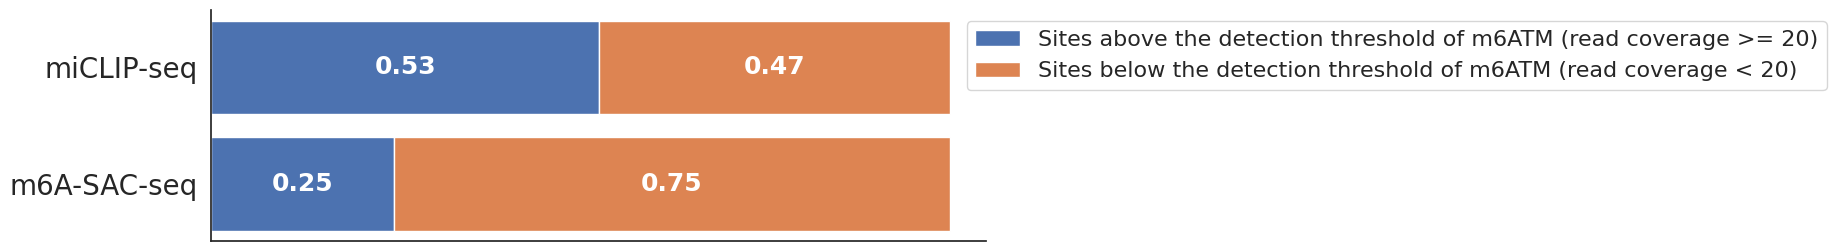

In [16]:
### bar plot 
# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette() # color palette
fig, ax = plt.subplots(figsize = (10, 3)) # figure size

rows = ['miCLIP-seq', 'm6A-SAC-seq']
val1 = [1-ratio_lost_miclip, 1-ratio_lost_sac]
val2 = [ratio_lost_miclip, ratio_lost_sac]

rect1 = ax.barh(rows, val1, align = 'center', height = 0.8, color = tab_color[0], label = 'val1')
rect2 = ax.barh(rows, val2, align = 'center', left = val1, height = 0.8, color = tab_color[1], label = 'val2')

ax.bar_label(rect1, fmt = '%.2f', label_type = 'center', fontsize = 18, weight = 'bold', color = 'white')
ax.bar_label(rect2, fmt = '%.2f', label_type = 'center', fontsize = 18, weight = 'bold', color = 'white')

plt.legend(labels  = ['Sites above the detection threshold of m6ATM (read coverage >= 20)', 'Sites below the detection threshold of m6ATM (read coverage < 20)'],
           fontsize = 16, bbox_to_anchor = (0.96, 1))

ax.invert_yaxis()
ax.set_xticks([])
ax.tick_params(labelsize = 20)
sns.despine()

plt.savefig(os.path.join(out_dir, 'figs_bar_ratio.png'), dpi = 300, bbox_inches = 'tight')

In [ ]:

ax.bar_label(rects3, fmt = '%.2f', padding = 2, fontsize = 18, weight = 'bold')
ax.bar_label(rects4, fmt = '%.2f', padding = 2, fontsize = 18, weight = 'bold')
ax.bar_label(rects5, fmt = '%.2f', padding = 2, fontsize = 18, weight = 'bold')

### Fig 3E

In [ ]:
data_dir = '/home/bo-yi/data/DRS/20210806_HEK293-WT/preprocessed'

In [ ]:
tx_file = '/home/bo-yi/data/ref/enst_hg38Tables.tsv'
ref_gn = '/home/bo-yi/data/ref/hg38.fa'

tx_df = pd.read_csv(tx_file, sep = '\t')
tx_df['name'] = [i.split('.')[0] for i in tx_df['name']]
ref_dict_gn = get_ref_dict(ref_gn)

In [ ]:
pred = pd.read_csv(os.path.join(data_dir, 'results_ivt20.csv'), index_col = 0)
pred_m6a = pred[pred.m6a == 'yes']
pred_m6a_gn = tx_to_gn(pred_m6a, tx_df, ref_dict_gn)

In [ ]:
with open (os.path.join(data_dir, 'motif.txt'), 'w') as f:
    for motif in pred_m6a_gn['motif']:
        f.write(motif.replace('T', 'U')+'\n')

In [ ]:
gt_dir = '/home/bo-yi/data/m6a_gt/hek293'

In [ ]:
### m6A-SAC-seq
sac_gt = pd.read_csv('/home/bo-yi/data/m6a_gt/hek293/sac/sac_sites_hek293.csv', header = 0, names = ['chr' , 'center', 'strand', 'ratio', 'kmer'])

with open (os.path.join(gt_dir, 'motif_sac.txt'), 'w') as f:
    for motif in sac_gt['kmer']:
        f.write(motif.replace('T', 'U')+'\n')

In [ ]:
### milclip
miclip_cims_gt = pd.read_csv('/home/bo-yi/data/m6a_gt/hek293/miclip/GSE63753_hek293.abcam.CIMS.m6A.9536.bed.txt', sep = '\t', header = None,
                             names = ['chr' ,'prior', 'center', 'peak_info', 'count', 'strand', 'kmer', 'coverage', 'ratio'])

with open (os.path.join(gt_dir, 'motif_miclip.txt'), 'w') as f:
    for motif in miclip_cims_gt['kmer']:
        f.write(motif.replace('T', 'U')+'\n')